# Network Types and Epidemic Modeling (Part 1)

## Introduction

This tutorial explores how **network structure** affects epidemic spread.

We will:

- **Examine different types of networks**
- **Simulate disease spread** using an agent-based SIR model
- **Compare network structures** via:
  - Degree distribution
  - Centrality measures
- **Evaluate epidemic outcomes:**
  - Final size
  - Duration
  - Peak prevalence

## Setup

To organize our workflow, we will create the following directory structure:

- `data/` — stores additional output files and datasets
- `figures/` — contains all generated figures
- `output/` — holds final result files

All results and visualizations will be saved in these directories for easy access and reproducibility.

In [30]:
# Navigate to the directory containing this file
    cd(@__DIR__)

# Create directories if they don't exist
    if !isdir("data")
        mkdir("data")
    end
    if !isdir("figures")
        mkdir("figures")
    end
    if !isdir("output")
        mkdir("output")
    end

Next, we activate the current directory as the environment for Pkg and import the required packages. This might take some time.

In [31]:
 # Import the Pkg module, activate the current directory as the environment for Pkg, instantiate the environment
    using Pkg
    Pkg.activate(@__DIR__)
    Pkg.instantiate()

  # Import the necessary packages
    using Agents, Graphs, Random, Plots, DataFrames, CSV, CategoricalArrays, Statistics, StatsBase, StatsPlots, Distributions, Measures

  Activating project at `c:\Users\Leonard\julia-workspace\espidam-tutorial-2025`


## Model Definition

The model is modular, with key components defined in separate source files:

1. **`create_graph.jl`**  
    *Constructs the network structure with a specified number of nodes (default: 1000) and topology.*

2. **`initialize.jl`**  
    *Handles model initialization, including agent placement and parameter setup.*

3. **`agent_step.jl`**  
    *Specifies the actions and transitions for each agent at every time step.*

4. **`model_step!`**  
    *Aggregates and records the number of individuals in each disease state (S, I, R).*

---

**Agent properties:**

- **Infection status:**  
  Susceptible (`S`), Infected (`I`), or Recovered (`R`)
- **Infection age:**  
  Number of days since infection
- **Risk category:**  
  Low or high risk

This modular approach enables flexible experimentation with different network structures and epidemic parameters.

In [32]:

include("src/create_graph.jl")

# Agent creation: agents of type Person and properties status, days_infected and risk
@agent struct Person(GraphAgent)
    status::Symbol = :S #((S)usceptible, (I)nfected, (R)ecovered)
    days_infected::Int = 0 # number of days since infection
    risk::Symbol = :high # something to differentiate agents (here, high and low risk)
end

include("src/initialize.jl")
include("src/agent_step.jl")

# Model step: keep track of the infection numbers
function model_step!(model::ABM)
    model.susceptible_count = sum([model[i].status == :S for i in 1:nv(model.graph)])
    model.infected_count = sum([model[i].status == :I for i in 1:nv(model.graph)])
    model.recovered_count = sum([model[i].status == :R for i in 1:nv(model.graph)])
end

model_step! (generic function with 1 method)

## Model Setup

Now let's set up the model for our investigation. In the initialization function, we can configure the following parameters:

### Key Parameters:

- **Network Type** (`network_type`): The structure of the network
- **Infection Seed** (`patient_zero`): Initial location of infection introduction. Options include:
  - `:random`: A randomly selected node (default)
  - `:maxdegree`: The node with the highest number of connections
  - `:maxbetweenness`: The node with highest betweenness centrality (most common on shortest paths)
  - `:maxeigenvector`: The node with highest eigenvector centrality (most connected to other well-connected nodes)
- **High-Risk Proportion** (`fraction_high_risk`): Fraction of population in high-risk category (used in Part 2)
- **Mean Degree** (`mean_degree`): Average connections per node

### Available Network Types:

| Type | Description |
|------|-------------|
| **Random** (`:random`) | Equal probability of connection between any nodes |
| **Small-World** (`:smallworld`) | High clustering with short average path lengths |
| **Preferential Attachment** (`:preferential`) | Scale-free networks with highly-connected hubs |
| **Configuration Model** (`:configuration`) (used in Part 2) | Specified degree distribution |
| **Proportionate Mixing** (`:proportionate`) (used in Part 2) | Specified distribution of agents with different properties |

In [33]:
# Initialization: initialize the model with the chosen parameters: network_type, patient_zero, mean_degree
model = initialize(; network_type=:random, patient_zero=:maxdegree, mean_degree=4)

StandardABM with 1000 agents of type Person
 agents container: Dict
 space: GraphSpace with 1000 positions and 2040 edges
 scheduler: fastest
 properties: days_to_recovered, trans_prob, mean_degree, high_risk, susceptible_count, low_risk_factor, fraction_high_risk, infected_count, recovered_count, graph, dispersion, n_nodes, patient_zero, network_type

## Network Analysis

The constructed network can be analyzed using our `analyze_graph` function, which returns a comprehensive set of network metrics:

### Calculated Metrics:

| **Category**            | **Metrics**                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| **Basic properties**    | Density, Mean degree, Clustering coefficient, Assortativity                 |
| **Component analysis**  | Number of connected components, Size distribution of components              |
| **Centrality measures** | Degree centrality, Betweenness centrality, Closeness centrality, Eigenvector centrality |
| **Structural properties** | Degree distribution, Maximal cliques, Network diameter                    |

Results are organized in a dictionary with easily accessible components for further analysis and visualization.

In [34]:

include("src/analyze_graph.jl")

# Analyze the graph
graph_analysis = analyze_graph(model.graph)

# Display the analysis results
analysis_display = print_graph_analysis(graph_analysis)

# Display each component of the analysis
display("Graph Summary Metrics")
display(analysis_display.summary)

display("Centrality Measures Statistics")
display(analysis_display.centrality)

display("Component Size Summary")
display(analysis_display.component_summary)

# Save the centrality measures to a CSV file for further analysis
CSV.write("data/centrality_$(model.network_type)_mdeg_$(model.mean_degree).csv", graph_analysis["centrality"]);

# Save summary metrics to a CSV file
CSV.write("data/graph_summary_$(model.network_type)_mdeg_$(model.mean_degree).csv", graph_analysis["summary"]);

"Graph Summary Metrics"

Row,metric,value
,String,Any
1,Mean Degree,4.08
2,Density,0.00408408
3,Clustering Coefficient,0.0050829
4,Assortativity,-0.0202531
5,Diameter,Graph is not connected
6,Number of Connected Components,16
7,Max Component Length,985


"Centrality Measures Statistics"

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,degree_centrality,0.00408408,0.0,0.004004,0.011011,0,Float64
2,betweenness_centrality,0.00393101,0.0,0.00294296,0.025487,0,Float64
3,closeness_centrality,0.193852,0.0,0.197418,0.240383,0,Float64
4,eigenvector_centrality,0.0256779,2.59777e-12,0.0214824,0.12834,0,Float64


"Component Size Summary"

Row,component_size,count
,Int64,Int64
1,1,15
2,985,1


## Network Visualization and Analysis

We can use the results from our network analysis to create visualizations that help us understand the network structure. We'll examine:

1. **Degree distribution** - The frequency of nodes with different numbers of connections
2. **Centrality measures** - How these relate to epidemic dynamics

These visualizations provide insights into network properties that influence disease spread.

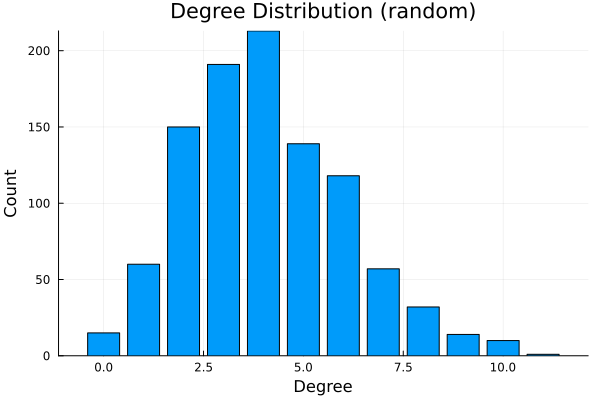

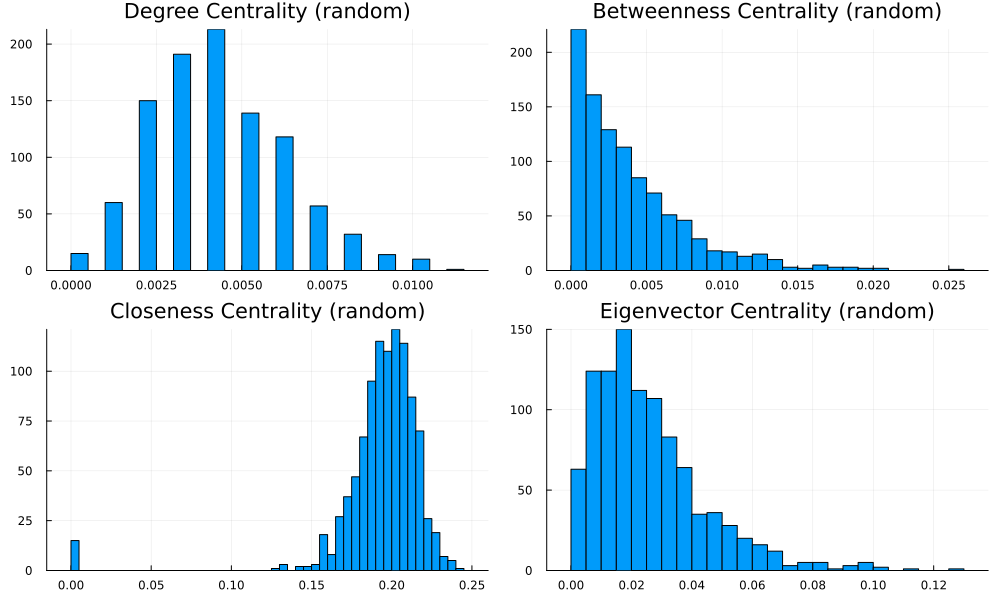

In [35]:

include("src/plotting.jl")

# Plot the degree distribution using our stored degree distribution data
plotdegdist = plot_degree_distribution(graph_analysis["degree_distribution"]; network_type=model.network_type)
display(plotdegdist)
savefig(plotdegdist, "figures/plotdegdist_$(model.network_type)_mdeg_$(model.mean_degree).pdf")

# Plot centrality distribution
p1 = histogram(graph_analysis["centrality"].degree_centrality, title="Degree Centrality ($(model.network_type))", legend=false)
p2 = histogram(graph_analysis["centrality"].betweenness_centrality, title="Betweenness Centrality ($(model.network_type))", legend=false)
p3 = histogram(graph_analysis["centrality"].closeness_centrality, title="Closeness Centrality ($(model.network_type))", legend=false)
p4 = histogram(graph_analysis["centrality"].eigenvector_centrality, title="Eigenvector Centrality ($(model.network_type))", legend=false)

centrality_plot = plot(p1, p2, p3, p4, layout=(2,2), size=(1000, 600))
display(centrality_plot)
savefig(centrality_plot, "figures/centrality_$(model.network_type)_mdeg_$(model.mean_degree).pdf");

## SIR Dynamics on the Random Network

To simulate the SIR dynamics, we use the `run!` function with the following parameters:

- **Model**: Our initialized network model
- **Duration**: Number of days to simulate
- **Data collection**:
  - `adata`: Agent-level data (infection status)
  - `mdata`: Model-level data (counts of S, I, R agents)

The simulation updates each agent's status based on interactions with their neighbors, following the rules defined in our agent_step.jl file.

Results are stored in DataFrames `adf` (agent data) and `mdf` (model data) for further analysis.

In [36]:
# specify "adata" (agent data to collect) and "mdata" (model data to collect)
adata = [:status]
mdata = [:susceptible_count, :infected_count, :recovered_count]

model = initialize(; network_type=:random, patient_zero=:maxdegree, mean_degree=4)
adf, mdf = run!(model, 100; adata, mdata);

## Epidemic Trajectory Visualization

The plot below illustrates the epidemic trajectories over time:

- **Susceptible**: Decreases as the infection spreads.
- **Infected**: Rises and falls as individuals become infected and then recover.
- **Recovered**: Increases as infected individuals recover.

Saved plot filename includes:
- *Network type: (e.g., `random`, `smallworld`, etc.)*
- *Mean degree*
- *Network size:* (number of nodes)
- *Dispersion parameter*
- *Patient zero selection method*
- *Risk parameters*
- *Transmission probability*

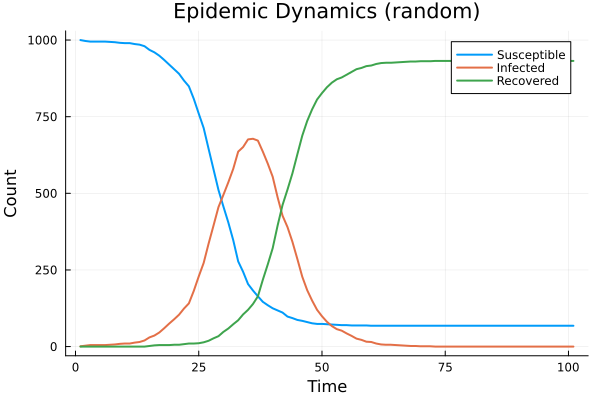

In [37]:
plotdynamics = plot_epidemic_trajectories(mdf, model.network_type)
display(plotdynamics)
savefig(plotdynamics, "figures/plotdynamics_$(model.network_type)_mdeg_$(model.mean_degree)_nn_$(model.n_nodes)_disp_$(model.dispersion)_pat0_$(model.patient_zero)_hirisk_$(model.high_risk)_hr_frac_$(model.fraction_high_risk)_trans_$(model.trans_prob).pdf");

## Single Run Visualization

Let's run a single simulation and examine both:
1. The epidemic dynamics plot (showing S, I, R counts over time)
2. The degree distribution plot (showing network connectivity patterns)

The `plot_single_run` function automatically initializes a new model with the specified parameters and returns both individual plots and a combined visualization, making it easy to analyze relationships between network structure and disease spread. The combined figures is saved in the `figures` directory.

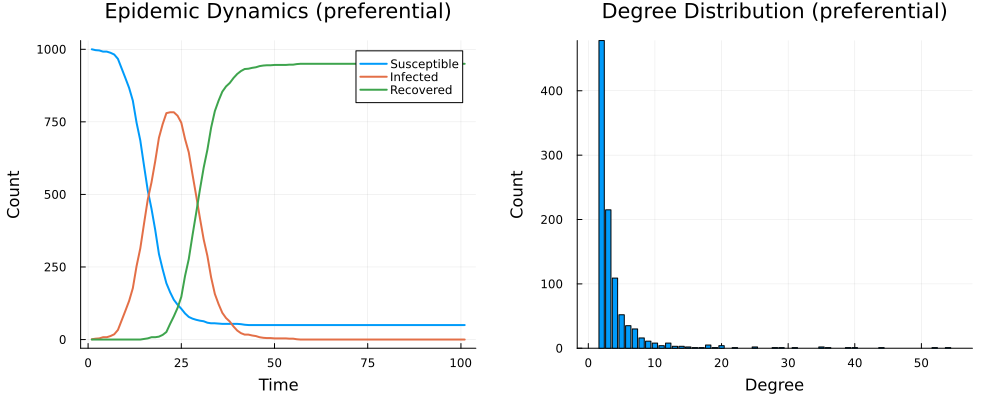

In [38]:
# Get both plots from plot_single_run
dynamics_plot, degdist_plot, combined_plot = plot_single_run(; network_type=:preferential, mean_degree=4)

display(combined_plot)

## Multiple Run Analysis

The `run_and_plot_comparison` function generates three key epidemic metrics across multiple simulation runs (100 in this case):

1. **Epidemic Duration**: Time from first to last infection
   - *Longer durations* may indicate slower but persistent spread

2. **Maximum Infected**: Peak number of simultaneous infections
   - *Higher peaks* suggest rapid spread that could overwhelm healthcare systems

3. **Susceptible Fraction Remaining**: Population proportion that escapes infection
   - *Lower values* indicate more complete spread through the population

These metrics help quantify how network structure influences epidemic outcomes, with results automatically saved to the figures directory.

> **Note:** Outliers are not shown in the boxplots.

Running simulations for random network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Saving combined comparison plot to figures/combined_comparison_mdeg_4.pdf


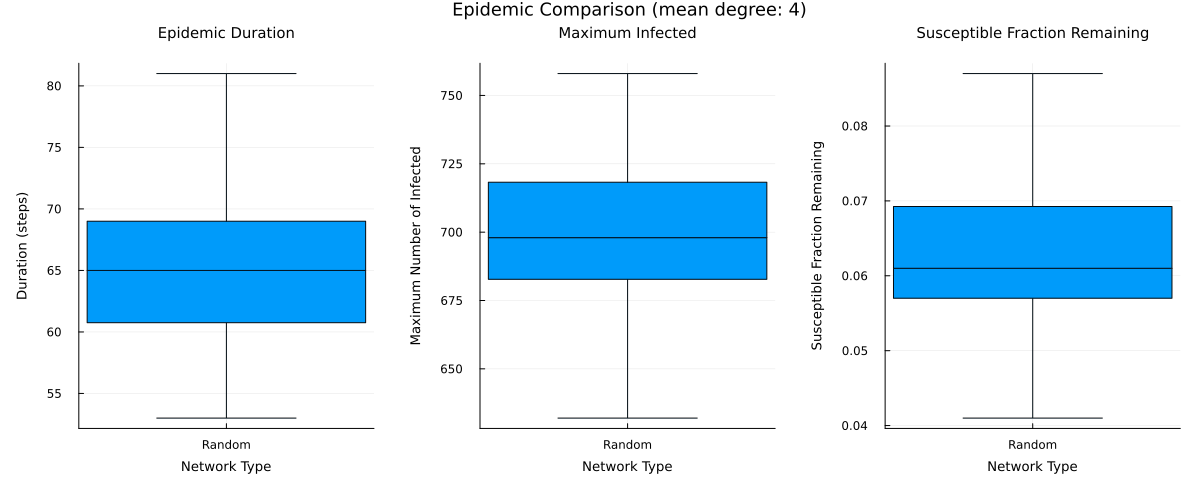

In [39]:
include("src/run_simulations.jl")
include("src/plotting.jl")
# Run simulations for multiple network types and compare their epidemic outcomes

combined_comparison = run_and_plot_comparison(
    network_types=[:random],
    mean_degree=4
    );

# Display the combined comparison plot
display(combined_comparison)

## Comparing Different Network Types

To understand how network structure influences epidemic dynamics, we can directly compare multiple network types side by side. By passing a vector of network types (e.g., `[:random, :preferential, :smallworld]`) to the simulation and plotting functions, we generate results for each network under identical conditions.

This approach allows us to:

- **Visualize epidemic trajectories** for each network type on the same axes
- **Compare key epidemic metrics** (such as duration, peak prevalence, and final size) across network structures
- **Identify structural features** (like clustering or degree distribution) that impact disease spread

Such comparisons highlight how properties unique to each network—such as the presence of hubs in preferential attachment networks or high clustering in small-world networks—can accelerate or slow down epidemic spread. This insight is crucial for designing effective intervention strategies tailored to specific contact patterns.

Running simulations for random network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Running simulations for preferential network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Running simulations for smallworld network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Saving combined comparison plot to figures/combined_comparison_mdeg_4.pdf


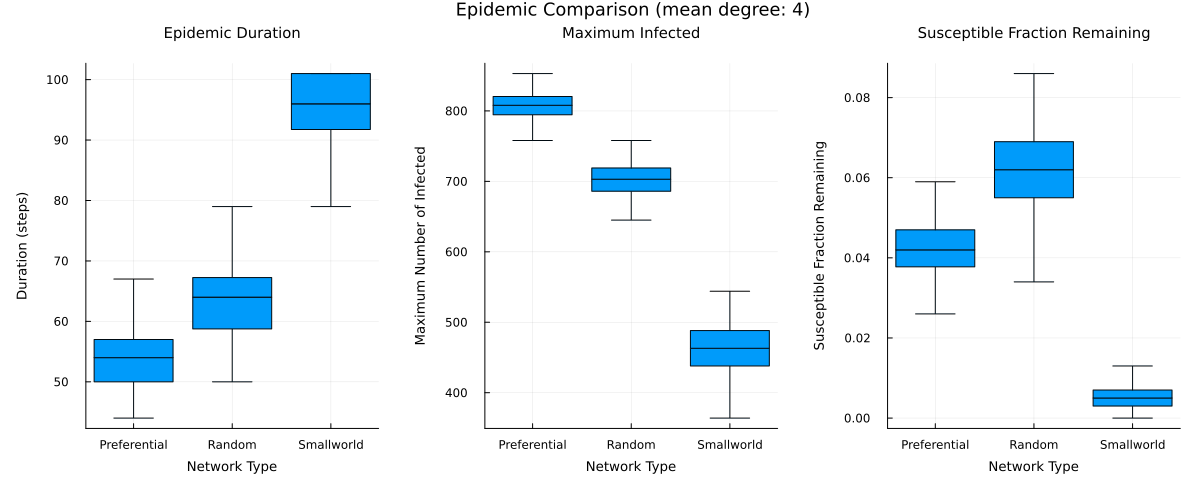

In [40]:
# Run simulations for multiple network types and compare their epidemic outcomes
combined_comparison = run_and_plot_comparison(
    network_types=[:random, :preferential, :smallworld],
    mean_degree=4,
);

# Display the combined comparison plot
display(combined_comparison)

## Network Metrics Comparison

Different network topologies possess distinct structural properties that influence disease transmission dynamics. We can visualize these differences using a chart that compares key metrics across network types:

### Structural Metrics:
- **Density**: Ratio of actual connections to all possible connections
- **Clustering coefficient**: Tendency of nodes to form tightly-knit groups
- **Assortativity**: Correlation between degrees of connected nodes
  - *Positive*: Similar-degree nodes connect (homophily)
  - *Negative*: Dissimilar-degree nodes connect (heterophily)

### Centrality Metrics:
- **Degree centrality**: Number of direct connections
- **Betweenness centrality**: Frequency of node appearing on shortest paths
- **Closeness centrality**: Average distance to all other nodes
- **Eigenvector centrality**: Connection to other important nodes

Our visualization makes it easy to compare metrics across different network types at a glance.

Analyzing random network...
Analyzing smallworld network...
Analyzing preferential network...
Saving network metrics comparison plot to figures/network_metrics_comparison_random_smallworld_preferential_mdeg_4.pdf


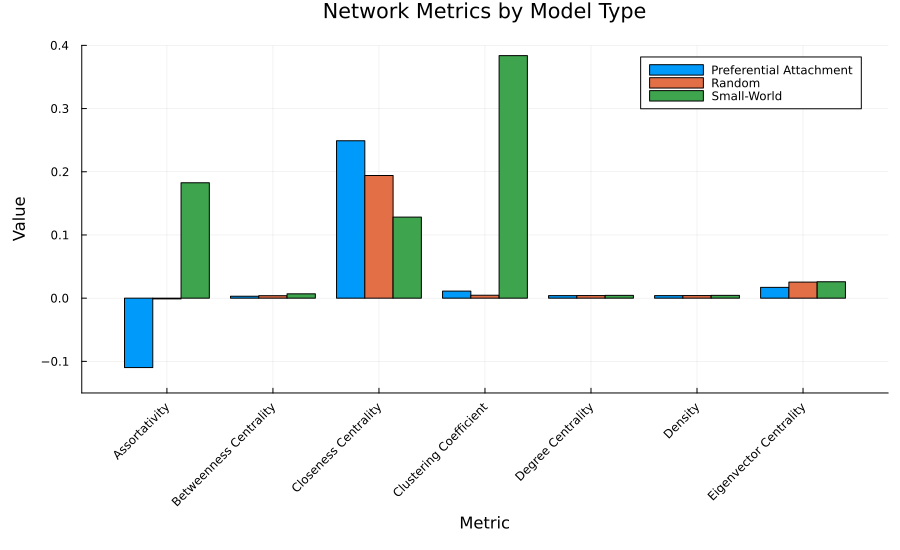

In [41]:
# Create a direct comparison of network metrics for different network types
include("src/plotting.jl")

# Use the new function to generate a comparison plot
metrics_plot = plot_network_metrics_comparison(
    network_types=[:random, :smallworld, :preferential],
    mean_degree=4
)

# Display the plot
display(metrics_plot)

<details>
<summary><strong>Spoiler: Observations from Network Metrics Comparison (click to expand)</strong></summary>

## Observations from Network Metrics Comparison

The bar chart reveals key structural differences between network types:

### Random Networks
- Show uniform connectivity patterns
- Low clustering coefficient
- Neutral assortativity (close to zero)

### Small-World Networks
- Significantly higher clustering coefficient
- Often moderate assortativity
- Higher closeness centrality due to "shortcut" connections

### Preferential Attachment Networks
- Often show negative assortativity (hubs connect to low-degree nodes)
- Highly skewed centrality distributions
- Scale-free structure with influential hubs

These structural differences help explain why epidemics spread differently across various network types. For example, hub nodes in preferential attachment networks can become superspreaders, while high clustering in small-world networks can initially slow spread but ultimately create efficient transmission pathways through shortcuts.

</details>

## Centrality Distribution Comparison

The boxplots below show the distribution of centrality measures across different network types:

### Centrality Measures:
- **Degree centrality**: Proportion of nodes directly connected to a node
- **Betweenness centrality**: Fraction of shortest paths passing through a node
- **Closeness centrality**: Inverse of the sum of shortest distances to all other nodes
- **Eigenvector centrality**: Measures influence based on connections to other influential nodes

The visualization highlights:
1. **Preferential attachment networks** show the highest variability in centrality measures, particularly in closeness centrality
2. **Small-world networks** have moderate closeness centrality values with less variation
3. **Random networks** generally show the lowest variability across centrality measures

These differences in centrality distributions directly impact how diseases spread through networks. Nodes with high centrality often serve as key transmission points in epidemics.

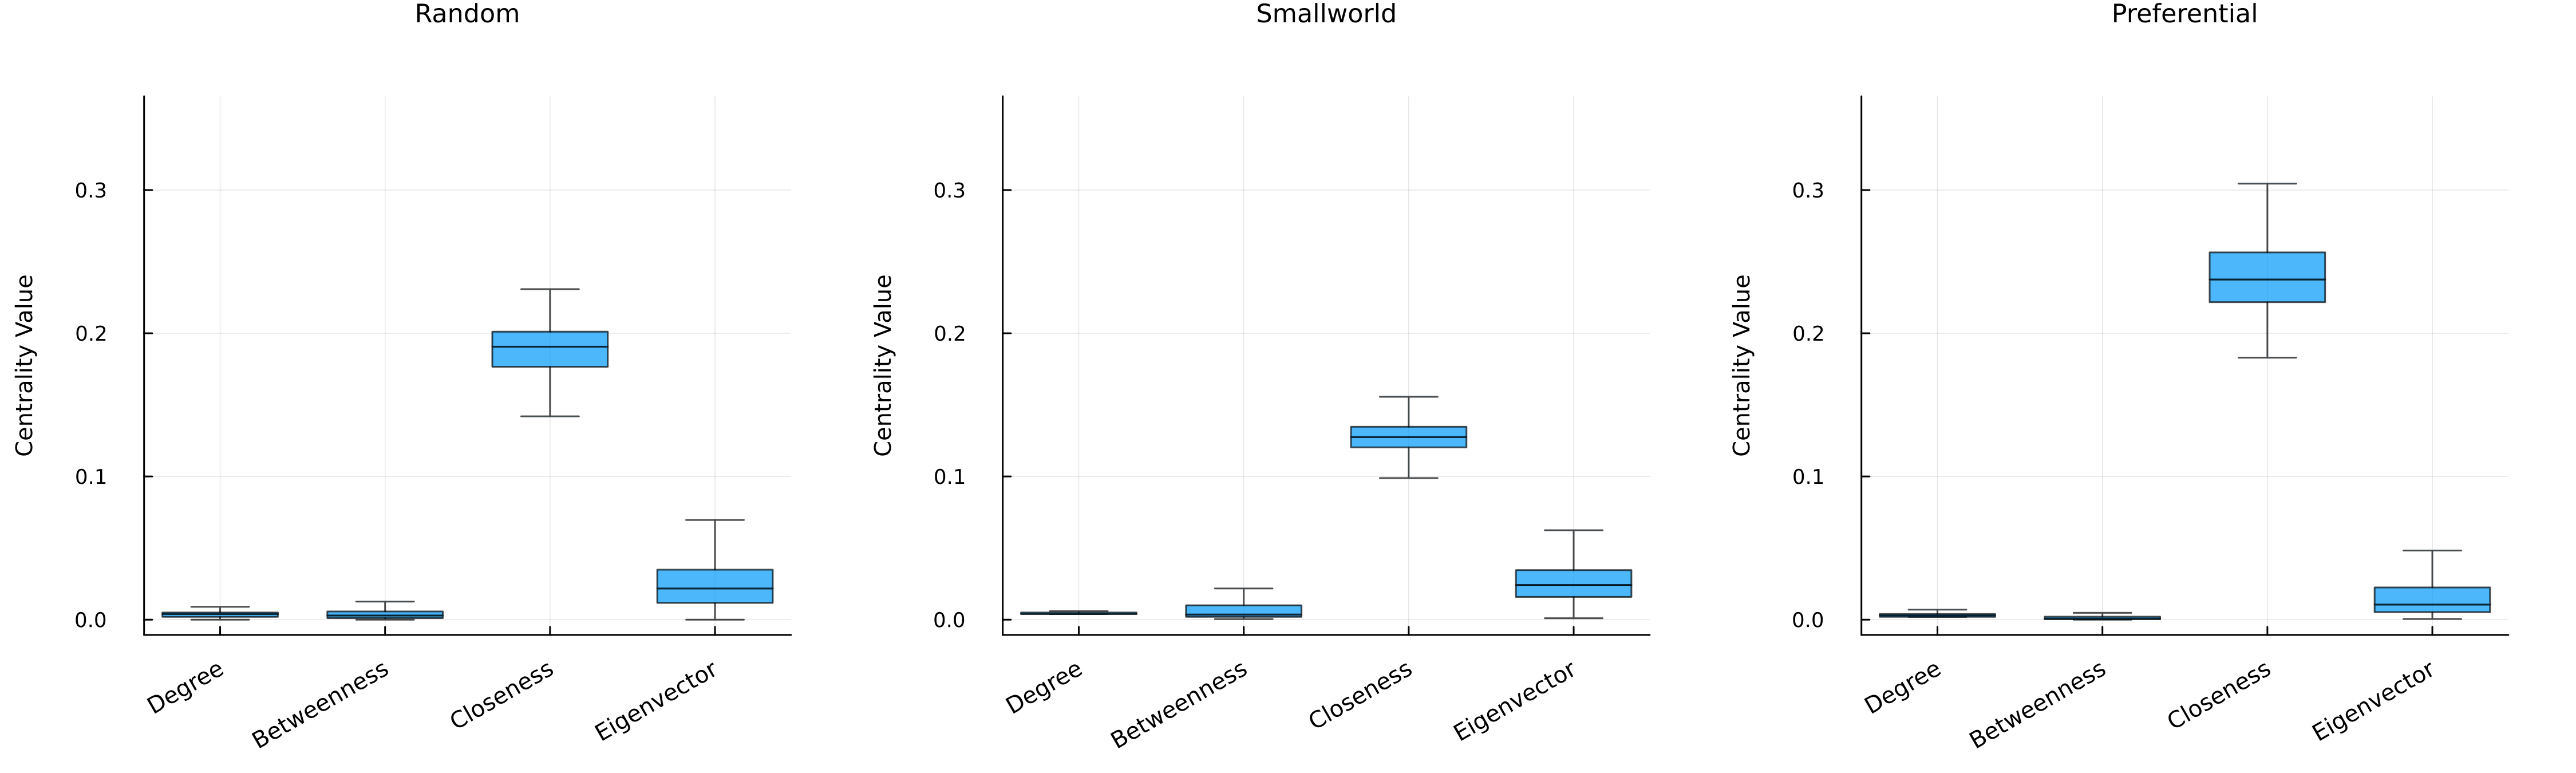

Saving combined centrality comparison plot to figures/centrality_comparison_random_smallworld_preferential_mdeg_4.pdf


In [42]:
include("src/plotting.jl")

centrality_comparison = plot_centrality_comparison(;
    network_types=[:random, :smallworld, :preferential], 
    mean_degree=4,
    link_axes=true  # Enable linked y-axes for direct comparison
)
display(centrality_comparison)